In [1]:
import jax.numpy as np
import numpy as onp
from jax import random, grad, jit, vmap
from functools import partial
key = random.PRNGKey(0)
from jax.experimental import optimizers
from NODE_ICNN_CANN_MF_fns import *
import matplotlib.pyplot as plt
import pickle
from jax.config import config
import pandas as pd
config.update("jax_enable_x64", True)
plt.rcParams.update({'font.size': 12})

import pandas as pd
from sklearn.metrics import r2_score

/opt/homebrew/lib/python3.9/site-packages/jax/_src/lib/__init__.py:33: UserWarning: JAX on Mac ARM machines is experimental and minimally tested. Please see https://github.com/google/jax/issues/5501 in the event of problems.
  warnings.warn("JAX on Mac ARM machines is experimental and minimally tested. "
/opt/homebrew/lib/python3.9/site-packages/jax/experimental/optimizers.py:28: FutureWarning: jax.experimental.optimizers is deprecated, import jax.example_libraries.optimizers instead
  warnings.warn('jax.experimental.optimizers is deprecated, '


# Train NODE, CANN, ICNN, MFNN, directly against rubber stress data

Train directly against the stress data from the three rubber datasets.
Note. I wanted to do these four different schemes. the last one I wanted to do was this MF scheme where I would combine a CANN with a NODE but that doesnt seem necessary in that the CANN and the NODE alone can do just fine for rubber data. So at least for rubber doesnt seem necessary. 

In [2]:
class CANN_model():
    def __init__(self, params_I1, params_I2,normalization):
        self.params_I1 = params_I1
        self.params_I2 = params_I2
        self.normalization = normalization
    # Psi1
    def Psi1norm(self, I1norm):
        # Note: I1norm = (I1-3)/normalization
        return CANN_dpsidInorm(I1norm,self.params_I1)[:,0]/normalization[0]
    # Psi2
    def Psi2norm(self, I2norm):
        # Note: I2norm = (I2-3)/normalization
        return CANN_dpsidInorm(I2norm,self.params_I2)[:,0]/normalization[1]

# play with ICNN a bit, how do we get that one to work
class ICNN_model():
    def __init__(self, params_I1, params_I2,normalization):
        self.params_I1 = params_I1
        self.params_I2 = params_I2
        self.normalization = normalization
    # Psi1
    # note: for ICNN the prediction is the function not the gradient
    # but the P11_UT, P11_ET, etc expects the model to output the derivative
    def Psi1norm(self, I1norm):
        # Note: I1norm = (I1-3)/normalization
        f1 = lambda x: icnn_forwardpass(x, self.params_I1)[0]
        #normalization = [I1_factor,I2_factor,Psi1_factor,Psi2_factor ]
        df1 = grad(f1)
        return vmap(df1)(I1norm[:,None])[:,0]/self.normalization[0]
    # Psi2
    # note: for ICNN the prediction is the function not the gradient
    def Psi2norm(self, I2norm):
        # Note: I2norm = (I2-3)/normalization
        f2 = lambda x: icnn_forwardpass(x, self.params_I2)[0]
        #normalization = [I1_factor,I2_factor,Psi1_factor,Psi2_factor ]
        df2 = grad(f2)
        return vmap(df2)(I2norm[:,None])[:,0]/self.normalization[1]
        
## NODE model outputs normalized strain energy given normalized invariants
class NODE_model():
    def __init__(self, params_I1, params_I2):
        self.params_I1 = params_I1
        self.params_I2 = params_I2
    def Psi1norm(self, I1norm):
        # Note: I1norm = (I1-3)/normalization
        return NODE_posb_vmap(I1norm, self.params_I1)
    def Psi2norm(self, I2norm):
        # Note: I2norm = (I2-3)/normalization
        return NODE_posb_vmap(I2norm, self.params_I2)

def plotstresses(x_gt,y_gt,x_pr,y_pr):
    fig, ax = plt.subplots(1,3,figsize=(12,4))
    labels = ['UT', 'ET', 'PS']
    for axi, x_gti, y_gti, x_pri, y_pri, label in zip(ax, x_gt, y_gt, x_pr, y_pr, labels):
        axi.plot(x_gti, y_gti, 'k.')
        axi.plot(x_pri, y_pri)
        axi.set_title(label)
        axi.set_xlabel(r'Stretch $\lambda [-]$')
        axi.set_ylabel(r'Nominal stress $P_{11} [MPa]$')
    return fig, ax

In [3]:
def P11_UT(lamb, model, normalization):
    I1_factor = normalization[0]
    I2_factor = normalization[1]
    Psi1_factor = normalization[2]
    Psi2_factor = normalization[3]
    I1 = lamb**2 + 2/lamb
    I2 = 2*lamb + 1/lamb**2
    I1norm = (I1-3)/I1_factor
    I2norm = (I2-3)/I2_factor
    Psi1 = model.Psi1norm(I1norm)*Psi1_factor
    Psi2 = model.Psi2norm(I2norm)*Psi2_factor
    return 2*(Psi1 + Psi2/lamb)*(lamb-1/lamb**2)
def P11_ET(lamb, model, normalization):
    I1_factor = normalization[0]
    I2_factor = normalization[1]
    Psi1_factor = normalization[2]
    Psi2_factor = normalization[3]
    I1 = 2*lamb**2 + 1/lamb**4
    I2 = lamb**4 + 2/lamb**2
    I1norm = (I1-3)/I1_factor
    I2norm = (I2-3)/I2_factor
    Psi1 = model.Psi1norm(I1norm)*Psi1_factor
    Psi2 = model.Psi2norm(I2norm)*Psi2_factor
    return 2*(Psi1 + Psi2*lamb**2)*(lamb-1/lamb**5)
def P11_PS(lamb, model, normalization):
    I1_factor = normalization[0]
    I2_factor = normalization[1]
    Psi1_factor = normalization[2]
    Psi2_factor = normalization[3]
    I1 =  lamb**2 + 1/lamb**2 + 1
    I2 =  lamb**2 + 1/lamb**2 + 1
    I1norm = (I1-3)/I1_factor
    I2norm = (I2-3)/I2_factor
    Psi1 = model.Psi1norm(I1norm)*Psi1_factor
    Psi2 = model.Psi2norm(I2norm)*Psi2_factor
    return 2*(Psi1+Psi2)*(lamb-1/lamb**3)

In [4]:
## Eval invariants for the three types of deformation
def evalI1_UT(lam):
    return lam**2 + (2/lam)
def evalI2_UT(lam):
    return 2*lam + (1/lam**2)

def evalI1_ET(lam):
    return 2*lam**2 +1/lam**4
def evalI2_ET(lam):
    return lam**4 + 2/lam**2

def evalI1_PS(lam):
    return lam**2 + 1/lam**2 + 1
def evalI2_PS(lam):
    return lam**2 + 1/lam**2 + 1

In [5]:
# read the data
UTdata = pd.read_csv('Data/UT20.csv')
ETdata = pd.read_csv('Data/ET20.csv')
PSdata = pd.read_csv('Data/PS20.csv')
# stack into single array 
P11_data = np.hstack([UTdata['P11'].to_numpy(),ETdata['P11'].to_numpy(),PSdata['P11'].to_numpy()])
F11_data = np.hstack([UTdata['F11'].to_numpy(),ETdata['F11'].to_numpy(),PSdata['F11'].to_numpy()])
# indices for the three data sets
indET = len(UTdata['P11'])
indPS = indET + len(ETdata['P11'])

Maximum I1 and I2 for different cases:
UT: 60, 15
ET: 40, 392
PS: 26, 26

In [6]:
I1_factor = 30
Psi1_factor = 0.3
I2_factor = 250
Psi2_factor = 0.001
normalization = [I1_factor,I2_factor,Psi1_factor,Psi2_factor ]

@partial(jit, static_argnums=(2,))
def loss_P11_all(params, F11_data, mdlnumber):
    lamUT = F11_data[0:indET]
    lamET = F11_data[indET:indPS]
    lamPS = F11_data[indPS:]
    params_I1 = params[0]
    params_I2 = params[1]
    if mdlnumber == 1:
        model = CANN_model(params_I1,params_I2,normalization)
    elif mdlnumber == 2:
        model = ICNN_model(params_I1,params_I2,normalization)
    else:
        model = NODE_model(params_I1,params_I2)
    P11UT_pr = P11_UT(lamUT, model, normalization)
    P11ET_pr = P11_ET(lamET, model, normalization)
    P11PS_pr = P11_PS(lamPS, model, normalization)    
    return np.mean((P11UT_pr-P11_data[0:indET])**2)+np.mean((P11ET_pr-P11_data[indET:indPS])**2)+np.mean((P11PS_pr-P11_data[indPS:])**2)

@partial(jit, static_argnums=(2,))
def loss_P11_UT(params, F11_data, mdlnumber):
    lamUT = F11_data[0:indET]
    params_I1 = params[0]
    params_I2 = params[1]
    if mdlnumber == 1:
        model = CANN_model(params_I1,params_I2,normalization)
    elif mdlnumber == 2:
        model = ICNN_model(params_I1,params_I2,normalization)
    else:
        model = NODE_model(params_I1,params_I2)
    P11UT_pr = P11_UT(lamUT, model, normalization)
    return np.mean((P11UT_pr-P11_data[0:indET])**2)

@partial(jit, static_argnums=(2,))
def loss_P11_ET(params, F11_data, mdlnumber):
    lamET = F11_data[indET:indPS]
    params_I1 = params[0]
    params_I2 = params[1]
    if mdlnumber == 1:
        model = CANN_model(params_I1,params_I2,normalization)
    elif mdlnumber == 2:
        model = ICNN_model(params_I1,params_I2,normalization)
    else:
        model = NODE_model(params_I1,params_I2)
    P11ET_pr = P11_ET(lamET, model, normalization)
    return np.mean((P11ET_pr-P11_data[indET:indPS])**2)

@partial(jit, static_argnums=(2,))
def loss_P11_PS(params, F11_data, mdlnumber):
    lamPS = F11_data[indPS:]
    params_I1 = params[0]
    params_I2 = params[1]
    if mdlnumber == 1:
        model = CANN_model(params_I1,params_I2,normalization)
    elif mdlnumber == 2:
        model = ICNN_model(params_I1,params_I2,normalization)
    else:
        model = NODE_model(params_I1,params_I2)
    P11PS_pr = P11_PS(lamPS, model, normalization)    
    return np.mean((P11PS_pr-P11_data[indPS:])**2)


@partial(jit, static_argnums=(0,1,))
def step_jp(loss, mdlnumber, i, opt_state, X_batch):
    params = get_params(opt_state)
    g = grad(loss)(params, X_batch, mdlnumber)
    return opt_update(i, g, opt_state)

def train_jp(loss, mdlnumber, X, opt_state, key, nIter = 10000, print_freq = 1000):
    train_loss = []
    val_loss = []
    for it in range(nIter):
        opt_state = step_jp(loss, mdlnumber, it, opt_state, X)         
        if (it+1)% print_freq == 0:
            params = get_params(opt_state)
            train_loss_value = loss(params, X, mdlnumber)
            train_loss.append(train_loss_value)
            to_print = "it %i, train loss = %e" % (it+1, train_loss_value)
            print(to_print)
    return get_params(opt_state), train_loss, val_loss


Using layers = [1,2,3,1] for node and [1,4,1] for icnn
n_params_cann = 2*12 = 24
n_params_icnn = 2*(4 + 8) = 24
n_params_node = 2*(2 + 6 + 3) = 22

In [7]:
def init_node(key, layers = [1,5,5,1]):
    params_I1 = init_params_posb(layers, key) 
    params_I2 = init_params_posb(layers, key)
    return [params_I1,params_I2]

def init_icnn(key, layers = [1,3,4,1]):
    params_I1 = init_params_icnn(layers, key)
    params_I2 = init_params_icnn(layers, key)
    return [params_I1,params_I2]

def init_cann(key, layers = None):
    params_I1 = init_params_cann(key)
    params_I2 = init_params_cann(key)
    return [params_I1,params_I2]

## NODE fits

### Fit all three tests at the same time

In [8]:
params_all = init_node(key)
opt_init, opt_update, get_params = optimizers.adam(2.e-4) #Original: 2.e-4
opt_state = opt_init(params_all)

mdlnumber = 3 #NODE
params_all, train_loss, val_loss = train_jp(loss_P11_all, mdlnumber, F11_data, opt_state, key, nIter = 50000) #Original 100000

it 1000, train loss = 5.585331e+00
it 2000, train loss = 4.111750e-01
it 3000, train loss = 1.728923e-01
it 4000, train loss = 1.308042e-01
it 5000, train loss = 9.964674e-02
it 6000, train loss = 8.227019e-02
it 7000, train loss = 7.528298e-02
it 8000, train loss = 7.222669e-02
it 9000, train loss = 6.889756e-02
it 10000, train loss = 6.419773e-02
it 11000, train loss = 5.835025e-02
it 12000, train loss = 5.193269e-02
it 13000, train loss = 4.550062e-02
it 14000, train loss = 3.955682e-02
it 15000, train loss = 3.444139e-02
it 16000, train loss = 3.027742e-02
it 17000, train loss = 2.700249e-02
it 18000, train loss = 2.449868e-02
it 19000, train loss = 2.263605e-02
it 20000, train loss = 2.128555e-02
it 21000, train loss = 2.033289e-02
it 22000, train loss = 1.969079e-02
it 23000, train loss = 1.930204e-02
it 24000, train loss = 1.908022e-02
it 25000, train loss = 1.895053e-02
it 26000, train loss = 1.886870e-02
it 27000, train loss = 1.881394e-02
it 28000, train loss = 1.877543e-02
i

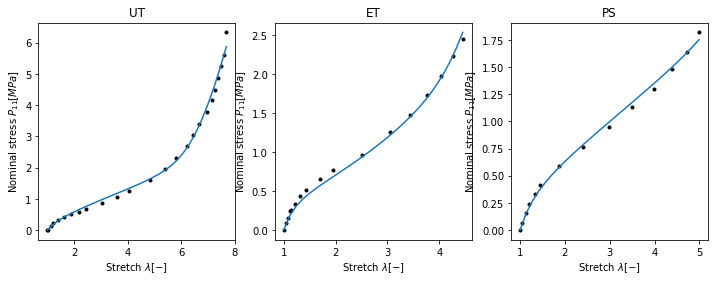

In [9]:
lamUT_vec = np.linspace(1,UTdata['F11'].iloc[-1],30)
lamET_vec = np.linspace(1,ETdata['F11'].iloc[-1],30)
lamPS_vec = np.linspace(1,PSdata['F11'].iloc[-1],30)

normalization = [I1_factor,I2_factor,Psi1_factor,Psi2_factor ]
model = NODE_model(params_all[0], params_all[1])
P11_NN_UT = P11_UT(lamUT_vec, model, normalization)
P11_NN_ET = P11_ET(lamET_vec, model, normalization)
P11_NN_PS = P11_PS(lamPS_vec, model, normalization) 

fig, ax = plotstresses([UTdata['F11'], ETdata['F11'], PSdata['F11']],
                       [UTdata['P11'], ETdata['P11'], PSdata['P11']],
                       [lamUT_vec, lamET_vec, lamPS_vec],
                       [P11_NN_UT, P11_NN_ET, P11_NN_PS])

In [10]:
# save the result with pickle
with open('savednet/NODE_params_all.npy', 'wb') as f:
    pickle.dump(params_all, f)

### NODE training with one set of data and comparing to the others 

In [11]:
# train with uniaxial only
params_UT = init_node(key)
opt_init, opt_update, get_params = optimizers.adam(5.e-4) #Original: 1.e-4
opt_state = opt_init(params_UT)
mdlnumber = 3 #NODE
params_UT, train_loss, val_loss = train_jp(loss_P11_UT, mdlnumber, F11_data, opt_state, key, nIter = 100000) #Original 100000

it 1000, train loss = 7.272730e-02
it 2000, train loss = 4.017158e-02
it 3000, train loss = 3.492846e-02
it 4000, train loss = 3.251616e-02
it 5000, train loss = 3.170074e-02
it 6000, train loss = 3.076195e-02
it 7000, train loss = 2.924254e-02
it 8000, train loss = 2.741605e-02
it 9000, train loss = 2.538205e-02
it 10000, train loss = 2.302985e-02
it 11000, train loss = 2.020118e-02
it 12000, train loss = 1.684912e-02
it 13000, train loss = 1.370411e-02
it 14000, train loss = 1.023368e-02
it 15000, train loss = 6.889880e-03
it 16000, train loss = 5.303637e-03
it 17000, train loss = 4.528757e-03
it 18000, train loss = 4.079923e-03
it 19000, train loss = 3.797400e-03
it 20000, train loss = 3.603793e-03
it 21000, train loss = 3.465828e-03
it 22000, train loss = 3.360338e-03
it 23000, train loss = 3.278122e-03
it 24000, train loss = 3.209995e-03
it 25000, train loss = 3.153007e-03
it 26000, train loss = 3.104119e-03
it 27000, train loss = 3.061661e-03
it 28000, train loss = 3.023903e-03
i

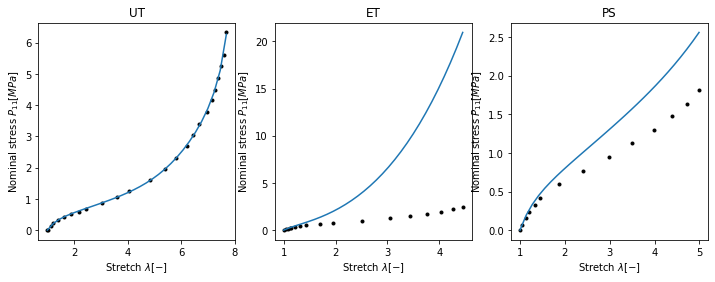

In [13]:

lamUT_vec = np.linspace(1,UTdata['F11'].iloc[-1],30)
lamET_vec = np.linspace(1,ETdata['F11'].iloc[-1],30)
lamPS_vec = np.linspace(1,PSdata['F11'].iloc[-1],30)

normalization = [I1_factor,I2_factor,Psi1_factor,Psi2_factor ]
model = NODE_model(params_UT[0], params_UT[1])
P11_NN_UT_u = P11_UT(lamUT_vec, model, normalization)
P11_NN_ET_u = P11_ET(lamET_vec, model, normalization)
P11_NN_PS_u = P11_PS(lamPS_vec, model, normalization) 

fig, ax = plotstresses([UTdata['F11'], ETdata['F11'], PSdata['F11']],
                       [UTdata['P11'], ETdata['P11'], PSdata['P11']],
                       [lamUT_vec, lamET_vec, lamPS_vec],
                       [P11_NN_UT_u, P11_NN_ET_u, P11_NN_PS_u])

In [14]:
# save the result with pickle
with open('savednet/NODE_params_UT.npy', 'wb') as f:
    pickle.dump(params_UT, f)

In [15]:
# train with equibiaxial only, 
params_ET = init_node(key)
opt_init, opt_update, get_params = optimizers.adam(2.e-4) #Original: 1.e-4
opt_state = opt_init(params_ET)
mdlnumber = 3
params_ET, train_loss, val_loss = train_jp(loss_P11_ET, mdlnumber, F11_data, opt_state, key, nIter = 100000) #Original 100000

it 1000, train loss = 5.448811e-01
it 2000, train loss = 4.745159e-02
it 3000, train loss = 3.288570e-02
it 4000, train loss = 2.635361e-02
it 5000, train loss = 1.974330e-02
it 6000, train loss = 1.435946e-02
it 7000, train loss = 1.057199e-02
it 8000, train loss = 7.834639e-03
it 9000, train loss = 5.688195e-03
it 10000, train loss = 3.952568e-03
it 11000, train loss = 2.650018e-03
it 12000, train loss = 1.834617e-03
it 13000, train loss = 1.409608e-03
it 14000, train loss = 1.131430e-03
it 15000, train loss = 8.619620e-04
it 16000, train loss = 6.474750e-04
it 17000, train loss = 4.940890e-04
it 18000, train loss = 3.914339e-04
it 19000, train loss = 3.273921e-04
it 20000, train loss = 2.910934e-04
it 21000, train loss = 2.732010e-04
it 22000, train loss = 2.660084e-04
it 23000, train loss = 2.616540e-04
it 24000, train loss = 2.500025e-04
it 25000, train loss = 2.382116e-04
it 26000, train loss = 2.283689e-04
it 27000, train loss = 2.204119e-04
it 28000, train loss = 2.138934e-04
i

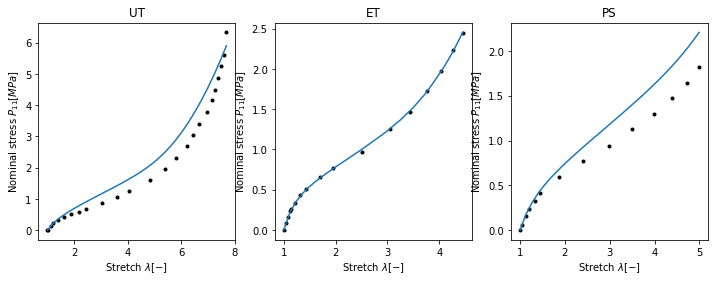

In [17]:
lamUT_vec = np.linspace(1,UTdata['F11'].iloc[-1],30)
lamET_vec = np.linspace(1,ETdata['F11'].iloc[-1],30)
lamPS_vec = np.linspace(1,PSdata['F11'].iloc[-1],30)

normalization = [I1_factor,I2_factor,Psi1_factor,Psi2_factor ]
model = NODE_model(params_ET[0], params_ET[1])
P11_NN_UT_e = P11_UT(lamUT_vec, model, normalization)
P11_NN_ET_e = P11_ET(lamET_vec, model, normalization)
P11_NN_PS_e = P11_PS(lamPS_vec, model, normalization) 

fig, ax = plotstresses([UTdata['F11'], ETdata['F11'], PSdata['F11']],
                       [UTdata['P11'], ETdata['P11'], PSdata['P11']],
                       [lamUT_vec, lamET_vec, lamPS_vec],
                       [P11_NN_UT_e, P11_NN_ET_e, P11_NN_PS_e])


In [18]:
# save the result with pickle
with open('savednet/NODE_params_ET.npy', 'wb') as f:
    pickle.dump(params_ET, f)

In [19]:
# train with pure shear only, 
params_PS = init_node(key)
opt_init, opt_update, get_params = optimizers.adam(2.e-4) #Original: 1.e-4
opt_state = opt_init(params_PS)
mdlnumber = 3
params_PS, train_loss, val_loss = train_jp(loss_P11_PS, mdlnumber, F11_data, opt_state, key, nIter = 100000) #Original 100000

it 1000, train loss = 4.510426e-01
it 2000, train loss = 2.592479e-02
it 3000, train loss = 1.638121e-02
it 4000, train loss = 1.542358e-02
it 5000, train loss = 1.410213e-02
it 6000, train loss = 1.243106e-02
it 7000, train loss = 1.055699e-02
it 8000, train loss = 8.663393e-03
it 9000, train loss = 6.865657e-03
it 10000, train loss = 5.205768e-03
it 11000, train loss = 3.759231e-03
it 12000, train loss = 2.658937e-03
it 13000, train loss = 1.915095e-03
it 14000, train loss = 1.465289e-03
it 15000, train loss = 1.224767e-03
it 16000, train loss = 1.108421e-03
it 17000, train loss = 1.041394e-03
it 18000, train loss = 9.630906e-04
it 19000, train loss = 8.781184e-04
it 20000, train loss = 8.030605e-04
it 21000, train loss = 7.394615e-04
it 22000, train loss = 6.865123e-04
it 23000, train loss = 6.450016e-04
it 24000, train loss = 6.138009e-04
it 25000, train loss = 5.899172e-04
it 26000, train loss = 5.705848e-04
it 27000, train loss = 5.538251e-04
it 28000, train loss = 5.388299e-04
i

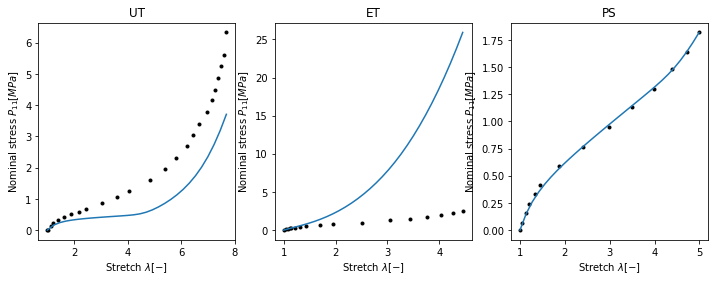

In [20]:
lamUT_vec = np.linspace(1,UTdata['F11'].iloc[-1],30)
lamET_vec = np.linspace(1,ETdata['F11'].iloc[-1],30)
lamPS_vec = np.linspace(1,PSdata['F11'].iloc[-1],30)

normalization = [I1_factor,I2_factor,Psi1_factor,Psi2_factor ]
model = NODE_model(params_PS[0], params_PS[1])
P11_NN_UT_p = P11_UT(lamUT_vec, model, normalization)
P11_NN_ET_p = P11_ET(lamET_vec, model, normalization)
P11_NN_PS_p = P11_PS(lamPS_vec, model, normalization) 

fig, ax = plotstresses([UTdata['F11'], ETdata['F11'], PSdata['F11']],
                       [UTdata['P11'], ETdata['P11'], PSdata['P11']],
                       [lamUT_vec, lamET_vec, lamPS_vec],
                       [P11_NN_UT_p, P11_NN_ET_p, P11_NN_PS_p])

In [21]:
# save the result with pickle
with open('savednet/NODE_params_PS.npy', 'wb') as f:
    pickle.dump(params_PS, f)

## Train ICNN model

In [ ]:
params_icnn_all = init_icnn(key)
opt_init, opt_update, get_params = optimizers.adam(2.e-4) #Original: 1.e-4
opt_state = opt_init(params_icnn_all)
mdlnumber = 2
params_icnn_all, train_loss, val_loss = train_jp(loss_P11_all, mdlnumber, F11_data, opt_state, key, nIter = 50000) #Original 100000

In [ ]:
lamUT_vec = np.linspace(1,UTdata['F11'].iloc[-1],30)
lamET_vec = np.linspace(1,ETdata['F11'].iloc[-1],30)
lamPS_vec = np.linspace(1,PSdata['F11'].iloc[-1],30)

normalization = [I1_factor,I2_factor,Psi1_factor,Psi2_factor ]
model = ICNN_model(params_icnn_all[0], params_icnn_all[1], normalization)
P11_NN_UT_p = P11_UT(lamUT_vec, model, normalization)
P11_NN_ET_p = P11_ET(lamET_vec, model, normalization)
P11_NN_PS_p = P11_PS(lamPS_vec, model, normalization) 

fig, ax = plotstresses([UTdata['F11'], ETdata['F11'], PSdata['F11']],
                       [UTdata['P11'], ETdata['P11'], PSdata['P11']],
                       [lamUT_vec, lamET_vec, lamPS_vec],
                       [P11_NN_UT_p, P11_NN_ET_p, P11_NN_PS_p])

In [ ]:
# save the result with pickle
with open('savednet/ICNN_params_all.npy', 'wb') as f:
    pickle.dump(params_icnn_all, f)

In [ ]:
# train with uniaxial only
params_icnn_UT = init_icnn(key)
opt_init, opt_update, get_params = optimizers.adam(2.e-4) #Original: 1.e-4
opt_state = opt_init(params_icnn_UT)
mdlnumber = 2
params_icnn_UT, train_loss, val_loss = train_jp(loss_P11_UT, mdlnumber, F11_data, opt_state, key, nIter = 100000) #Original 100000

In [ ]:
lamUT_vec = np.linspace(1,UTdata['F11'].iloc[-1],30)
lamET_vec = np.linspace(1,ETdata['F11'].iloc[-1],30)
lamPS_vec = np.linspace(1,PSdata['F11'].iloc[-1],30)

normalization = [I1_factor,I2_factor,Psi1_factor,Psi2_factor ]
model = ICNN_model(params_icnn_UT[0], params_icnn_UT[1], normalization)
P11_NN_UT_p = P11_UT(lamUT_vec, model, normalization)
P11_NN_ET_p = P11_ET(lamET_vec, model, normalization)
P11_NN_PS_p = P11_PS(lamPS_vec, model, normalization) 

fig, ax = plotstresses([UTdata['F11'], ETdata['F11'], PSdata['F11']],
                       [UTdata['P11'], ETdata['P11'], PSdata['P11']],
                       [lamUT_vec, lamET_vec, lamPS_vec],
                       [P11_NN_UT_p, P11_NN_ET_p, P11_NN_PS_p])

In [ ]:
# save the result with pickle
with open('savednet/ICNN_params_UT.npy', 'wb') as f:
    pickle.dump(params_icnn_UT, f)

In [ ]:
# train with equibiaxial only
params_icnn_ET = init_icnn(key)
opt_init, opt_update, get_params = optimizers.adam(2.e-4) #Original: 1.e-4
opt_state = opt_init(params_icnn_ET)
mdlnumber = 2
params_icnn_ET, train_loss, val_loss = train_jp(loss_P11_ET, mdlnumber, F11_data, opt_state, key, nIter = 100000) #Original 100000

In [ ]:
lamUT_vec = np.linspace(1,UTdata['F11'].iloc[-1],30)
lamET_vec = np.linspace(1,ETdata['F11'].iloc[-1],30)
lamPS_vec = np.linspace(1,PSdata['F11'].iloc[-1],30)

normalization = [I1_factor,I2_factor,Psi1_factor,Psi2_factor ]
model = ICNN_model(params_icnn_ET[0], params_icnn_ET[1], normalization)
P11_NN_UT_p = P11_UT(lamUT_vec, model, normalization)
P11_NN_ET_p = P11_ET(lamET_vec, model, normalization)
P11_NN_PS_p = P11_PS(lamPS_vec, model, normalization) 

fig, ax = plotstresses([UTdata['F11'], ETdata['F11'], PSdata['F11']],
                       [UTdata['P11'], ETdata['P11'], PSdata['P11']],
                       [lamUT_vec, lamET_vec, lamPS_vec],
                       [P11_NN_UT_p, P11_NN_ET_p, P11_NN_PS_p])

In [ ]:
# save the result with pickle
with open('savednet/ICNN_params_ET.npy', 'wb') as f:
    pickle.dump(params_icnn_ET, f)

In [ ]:
# train with equibiaxial only
params_icnn_PS = init_icnn(key)
opt_init, opt_update, get_params = optimizers.adam(2.e-4) #Original: 1.e-4
opt_state = opt_init(params_icnn_PS)
mdlnumber = 2
params_icnn_PS, train_loss, val_loss = train_jp(loss_P11_PS, mdlnumber, F11_data, opt_state, key, nIter = 100000) #Original 100000

In [ ]:
lamUT_vec = np.linspace(1,UTdata['F11'].iloc[-1],30)
lamET_vec = np.linspace(1,ETdata['F11'].iloc[-1],30)
lamPS_vec = np.linspace(1,PSdata['F11'].iloc[-1],30)

normalization = [I1_factor,I2_factor,Psi1_factor,Psi2_factor ]
model = ICNN_model(params_icnn_PS[0], params_icnn_PS[1], normalization)
P11_NN_UT_p = P11_UT(lamUT_vec, model, normalization)
P11_NN_ET_p = P11_ET(lamET_vec, model, normalization)
P11_NN_PS_p = P11_PS(lamPS_vec, model, normalization) 

fig, ax = plotstresses([UTdata['F11'], ETdata['F11'], PSdata['F11']],
                       [UTdata['P11'], ETdata['P11'], PSdata['P11']],
                       [lamUT_vec, lamET_vec, lamPS_vec],
                       [P11_NN_UT_p, P11_NN_ET_p, P11_NN_PS_p])

In [ ]:
# save the result with pickle
with open('savednet/ICNN_params_PS.npy', 'wb') as f:
    pickle.dump(params_icnn_PS, f)

## Train CANN model

In [ ]:
params_cann_all = init_cann(key)
opt_init, opt_update, get_params = optimizers.adam(2.e-4) #Original: 1.e-4
opt_state = opt_init(params_cann_all)
mdlnumber = 1
params_cann_all, train_loss, val_loss = train_jp(loss_P11_all, mdlnumber, F11_data, opt_state, key, nIter = 50000) #Original 100000

In [ ]:
lamUT_vec = np.linspace(1,UTdata['F11'].iloc[-1],30)
lamET_vec = np.linspace(1,ETdata['F11'].iloc[-1],30)
lamPS_vec = np.linspace(1,PSdata['F11'].iloc[-1],30)

normalization = [I1_factor,I2_factor,Psi1_factor,Psi2_factor ]
model = CANN_model(params_cann_all[0], params_cann_all[1], normalization)
P11_NN_UT_p = P11_UT(lamUT_vec, model, normalization)
P11_NN_ET_p = P11_ET(lamET_vec, model, normalization)
P11_NN_PS_p = P11_PS(lamPS_vec, model, normalization) 

fig, ax = plotstresses([UTdata['F11'], ETdata['F11'], PSdata['F11']],
                       [UTdata['P11'], ETdata['P11'], PSdata['P11']],
                       [lamUT_vec, lamET_vec, lamPS_vec],
                       [P11_NN_UT_p, P11_NN_ET_p, P11_NN_PS_p])

In [ ]:
# save the result with pickle
with open('savednet/CANN_params_all.npy', 'wb') as f:
    pickle.dump(params_cann_all, f)

In [ ]:
params_cann_UT = init_cann(key)
opt_init, opt_update, get_params = optimizers.adam(2.e-4) #Original: 1.e-4
opt_state = opt_init(params_cann_UT)
mdlnumber = 1
params_cann_UT, train_loss, val_loss = train_jp(loss_P11_UT, mdlnumber, F11_data, opt_state, key, nIter = 100000) #Original 100000

In [ ]:
lamUT_vec = np.linspace(1,UTdata['F11'].iloc[-1],30)
lamET_vec = np.linspace(1,ETdata['F11'].iloc[-1],30)
lamPS_vec = np.linspace(1,PSdata['F11'].iloc[-1],30)

normalization = [I1_factor,I2_factor,Psi1_factor,Psi2_factor ]
model = CANN_model(params_cann_UT[0], params_cann_UT[1], normalization)
P11_NN_UT_p = P11_UT(lamUT_vec, model, normalization)
P11_NN_ET_p = P11_ET(lamET_vec, model, normalization)
P11_NN_PS_p = P11_PS(lamPS_vec, model, normalization) 

fig, ax = plotstresses([UTdata['F11'], ETdata['F11'], PSdata['F11']],
                       [UTdata['P11'], ETdata['P11'], PSdata['P11']],
                       [lamUT_vec, lamET_vec, lamPS_vec],
                       [P11_NN_UT_p, P11_NN_ET_p, P11_NN_PS_p])

In [ ]:
# save the result with pickle
with open('savednet/CANN_params_UT.npy', 'wb') as f:
    pickle.dump(params_cann_UT, f)

In [ ]:
params_cann_ET = init_cann(key)
opt_init, opt_update, get_params = optimizers.adam(2.e-4) #Original: 1.e-4
opt_state = opt_init(params_cann_ET)
mdlnumber = 1
params_cann_ET, train_loss, val_loss = train_jp(loss_P11_ET, mdlnumber, F11_data, opt_state, key, nIter = 100000) #Original 100000

In [ ]:
lamUT_vec = np.linspace(1,UTdata['F11'].iloc[-1],30)
lamET_vec = np.linspace(1,ETdata['F11'].iloc[-1],30)
lamPS_vec = np.linspace(1,PSdata['F11'].iloc[-1],30)

normalization = [I1_factor,I2_factor,Psi1_factor,Psi2_factor ]
model = CANN_model(params_cann_ET[0], params_cann_ET[1], normalization)
P11_NN_UT_p = P11_UT(lamUT_vec, model, normalization)
P11_NN_ET_p = P11_ET(lamET_vec, model, normalization)
P11_NN_PS_p = P11_PS(lamPS_vec, model, normalization) 

fig, ax = plotstresses([UTdata['F11'], ETdata['F11'], PSdata['F11']],
                       [UTdata['P11'], ETdata['P11'], PSdata['P11']],
                       [lamUT_vec, lamET_vec, lamPS_vec],
                       [P11_NN_UT_p, P11_NN_ET_p, P11_NN_PS_p])

In [ ]:
# save the result with pickle
with open('savednet/CANN_params_ET.npy', 'wb') as f:
    pickle.dump(params_cann_ET, f)

In [ ]:
params_cann_PS = init_cann(key)
opt_init, opt_update, get_params = optimizers.adam(2.e-4) #Original: 1.e-4
opt_state = opt_init(params_cann_PS)
mdlnumber = 1
params_cann_PS, train_loss, val_loss = train_jp(loss_P11_PS, mdlnumber, F11_data, opt_state, key, nIter = 100000) #Original 100000

In [ ]:
lamUT_vec = np.linspace(1,UTdata['F11'].iloc[-1],30)
lamET_vec = np.linspace(1,ETdata['F11'].iloc[-1],30)
lamPS_vec = np.linspace(1,PSdata['F11'].iloc[-1],30)

normalization = [I1_factor,I2_factor,Psi1_factor,Psi2_factor ]
model = CANN_model(params_cann_PS[0], params_cann_PS[1], normalization)
P11_NN_UT_p = P11_UT(lamUT_vec, model, normalization)
P11_NN_ET_p = P11_ET(lamET_vec, model, normalization)
P11_NN_PS_p = P11_PS(lamPS_vec, model, normalization) 

fig, ax = plotstresses([UTdata['F11'], ETdata['F11'], PSdata['F11']],
                       [UTdata['P11'], ETdata['P11'], PSdata['P11']],
                       [lamUT_vec, lamET_vec, lamPS_vec],
                       [P11_NN_UT_p, P11_NN_ET_p, P11_NN_PS_p])

In [ ]:
with open('savednet/CANN_params_PS.npy', 'wb') as f:
    pickle.dump(params_cann_PS, f)

## PLOT ALL RESULTS

In [22]:
I1_factor = 30
Psi1_factor = 0.3
I2_factor = 250
Psi2_factor = 0.001
normalization = [I1_factor,I2_factor,Psi1_factor,Psi2_factor ]
UTdata = pd.read_csv('Data/UT20.csv')
ETdata = pd.read_csv('Data/ET20.csv')
PSdata = pd.read_csv('Data/PS20.csv')

# ALL
with open('savednet/NODE_params_all.npy', 'rb') as f:
    params_node_all = pickle.load(f)
with open('savednet/ICNN_params_all.npy', 'rb') as f:
    params_icnn_all = pickle.load(f)
with open('savednet/CANN_params_all.npy', 'rb') as f:
    params_cann_all = pickle.load(f)

# UT
with open('savednet/NODE_params_UT.npy', 'rb') as f:
    params_node_UT = pickle.load(f)
with open('savednet/ICNN_params_UT.npy', 'rb') as f:
    params_icnn_UT = pickle.load(f)
with open('savednet/CANN_params_UT.npy', 'rb') as f:
    params_cann_UT = pickle.load(f)

# ET
with open('savednet/NODE_params_ET.npy', 'rb') as f:
    params_node_ET = pickle.load(f)
with open('savednet/ICNN_params_ET.npy', 'rb') as f:
    params_icnn_ET = pickle.load(f)
with open('savednet/CANN_params_ET.npy', 'rb') as f:
    params_cann_ET = pickle.load(f)

# PS
with open('savednet/NODE_params_PS.npy', 'rb') as f:
    params_node_PS = pickle.load(f)
with open('savednet/ICNN_params_PS.npy', 'rb') as f:
    params_icnn_PS = pickle.load(f)
with open('savednet/CANN_params_PS.npy', 'rb') as f:
    params_cann_PS = pickle.load(f)

params_UT = [params_cann_UT, params_icnn_UT, params_node_UT]
params_ET = [params_cann_ET, params_icnn_ET, params_node_ET]
params_PS = [params_cann_PS, params_icnn_PS, params_node_PS]
params_all = [params_cann_all, params_icnn_all, params_node_all]
params = [params_UT, params_ET, params_PS, params_all]

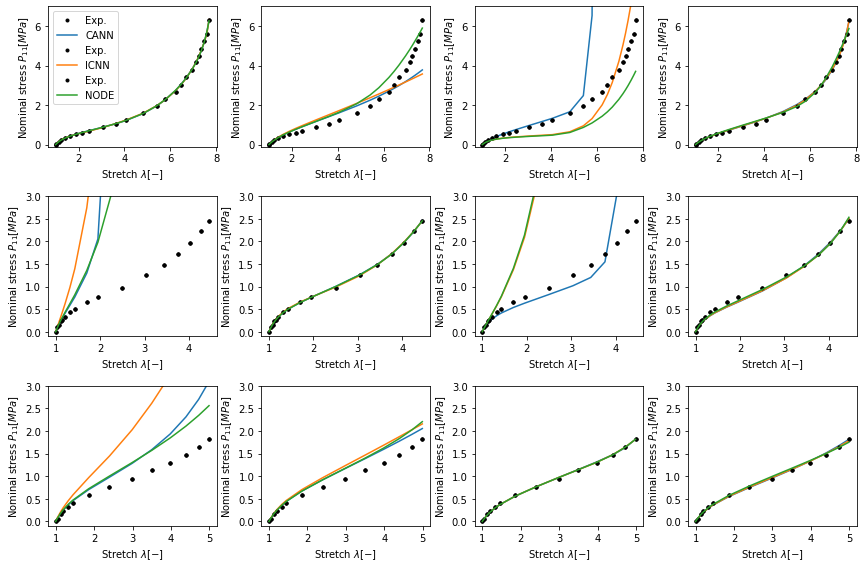

In [28]:
fig,axs = plt.subplots(3,4,figsize=(12,8))

lamUT_vec = np.array(UTdata['F11'])
lamET_vec = np.array(ETdata['F11'])
lamPS_vec = np.array(PSdata['F11'])

normalization = [I1_factor,I2_factor,Psi1_factor,Psi2_factor ]
panels_list = [['a', 'e', 'i'], ['b', 'f', 'j'], ['c', 'g', 'k'], ['d', 'h', 'l']]
cann_r2 = []
icnn_r2 = []
node_r2 = []

for axi, paramsi, panels in zip(axs.T, params, panels_list): #loop over columns
    params_cann, params_icnn, params_node = paramsi

    cann_model = CANN_model(params_cann[0], params_cann[1], normalization)
    icnn_model = ICNN_model(params_icnn[0], params_icnn[1], normalization)
    node_model = NODE_model(params_node[0], params_node[1])

    models = [cann_model, icnn_model, node_model]
    modelnames = ['CANN', 'ICNN', 'NODE']
    r2lists = [[],[],[]]
    for model, modelname, r2list in zip(models, modelnames, r2lists):
        P11funs = [P11_UT, P11_ET, P11_PS]
        lambdas = [lamUT_vec, lamET_vec, lamPS_vec]
        ylims = [[-0.1,7], [-0.1,3], [-0.1,3]]
        P11_gt_list = [UTdata['P11'], ETdata['P11'], PSdata['P11']]

        for axii, P11fun, lam, ylim, P11_gt, panel in zip(axi, P11funs, lambdas, ylims, P11_gt_list, panels): #loop over rows
            # plot gt values
            axii.plot(lam, P11_gt, 'k.', label='Exp.')

            # plot pr values
            P11 = P11fun(lam, model, normalization)
            axii.plot(lam, P11, label=modelname)
            axii.set(ylim=ylim, xlabel = r'Stretch $\lambda [-]$', ylabel = r'Nominal stress $P_{11} [MPa]$')

            # # calculate r2
            # r2 = r2_score(P11_gt, P11)
            # r2 = np.clip(r2, a_min=0.0, a_max=1.0)
            # r2list.append(r2)

            # save for TikZ
            data = np.array([lam, P11_gt]).T
            onp.savetxt('TikZ/fig_rubber_data/data_'+panel+'.csv', data, delimiter = ' ')
            P11 = np.clip(P11, a_min=-100, a_max = 100)
            data = np.array([lam, P11]).T
            onp.savetxt('TikZ/fig_rubber_data/'+modelname+'_'+panel+'.csv', data, delimiter = ' ')
        
    cann_r2.append(r2lists[0])
    icnn_r2.append(r2lists[1])
    node_r2.append(r2lists[2])
axs[0,0].legend()
fig.tight_layout()

# r2list = [cann_r2, icnn_r2, node_r2]
# columns = ['x', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l']
# for r2, x, modelname in zip(r2list, [0,1,2], modelnames):
#     r2 = onp.array(r2).T.flatten()
#     r2 = np.hstack([x, r2])
#     r2 = np.expand_dims(r2, axis=0)
#     df = pd.DataFrame(r2, columns=columns)
#     df.to_csv('TikZ/fig_rubberR2_data/'+modelname+'.csv', index=False, sep = ' ')

## 50 runs

In [29]:
# Next: find the standard deviation of R2 from 50 runs for each case.
# Takes more than 3 hours to finish
lamUT_vec = np.array(UTdata['F11'])
lamET_vec = np.array(ETdata['F11'])
lamPS_vec = np.array(PSdata['F11'])

cann_r2 = []
icnn_r2 = []
node_r2 = []
for i in range(50):
    print(i)
    cann_r2i = []
    icnn_r2i = []
    node_r2i = []
    r2lists     = [cann_r2i,    icnn_r2i,   node_r2i    ]
    mdlnumbers  = [1,           2,          3           ]
    init_fns    = [init_cann,   init_icnn,  init_node   ]
    MODELS      = [CANN_model,  ICNN_model, NODE_model  ]

    for mdlnumber, init_fn, MODEL, r2list in zip(mdlnumbers, init_fns, MODELS, r2lists):
        for loss_fn in ([loss_P11_UT, loss_P11_ET, loss_P11_PS, loss_P11_all]):
            key, subkey = random.split(key)
            params = init_fn(key)
            opt_init, opt_update, get_params = optimizers.adam(2.e-4) #Original: 1.e-4
            opt_state = opt_init(params)
            params, train_loss, val_loss = train_jp(loss_fn, mdlnumber, F11_data, opt_state, key, nIter = 100000, print_freq=200000)

            #make predictions
            if mdlnumber == 3:
                model = MODEL(params[0], params[1])
            else:
                model = MODEL(params[0], params[1], normalization)

            lambdas     = [lamUT_vec,       lamET_vec,      lamPS_vec       ]
            P11_gt_list = [UTdata['P11'],   ETdata['P11'],  PSdata['P11']   ]
            P11funs     = [P11_UT,          P11_ET,         P11_PS          ]
            for lam, P11_gt, P11fun in zip(lambdas, P11_gt_list, P11funs):
                P11 = P11fun(lam, model, normalization)
                r2 = r2_score(P11_gt, P11)
                r2list.append(r2)
    cann_r2.append(cann_r2i)
    icnn_r2.append(icnn_r2i)
    node_r2.append(node_r2i)


0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49


In [30]:
CANN_r2 = np.array(cann_r2)
ICNN_r2 = np.array(icnn_r2)
NODE_r2 = np.array(node_r2)
with open('savednet/CANN_r2_alldata.npy', 'wb') as f:
    pickle.dump(CANN_r2, f)
with open('savednet/ICNN_r2_alldata.npy', 'wb') as f:
    pickle.dump(ICNN_r2, f)
with open('savednet/NODE_r2_alldata.npy', 'wb') as f:
    pickle.dump(NODE_r2, f)

In [31]:
CANN_r2 = np.clip(CANN_r2, a_min=0.0, a_max=1.0)
ICNN_r2 = np.clip(ICNN_r2, a_min=0.0, a_max=1.0)
NODE_r2 = np.clip(NODE_r2, a_min=0.0, a_max=1.0)

CANN_r2_mean = np.mean(CANN_r2,axis=0)
CANN_r2_stdv = np.std(CANN_r2,axis=0)

ICNN_r2_mean = np.mean(ICNN_r2,axis=0)
ICNN_r2_stdv = np.std(ICNN_r2,axis=0)

NODE_r2_mean = np.mean(NODE_r2,axis=0)
NODE_r2_stdv = np.std(NODE_r2,axis=0)

# Save for TikZ
xs       = [0.0,          1.0,          2.0]
r2_means = [CANN_r2_mean, ICNN_r2_mean, NODE_r2_mean]
r2_stdvs = [CANN_r2_stdv, ICNN_r2_stdv, NODE_r2_stdv]
names = ['CANN', 'ICNN', 'NODE']
for name, x, r2_mean, r2_stdv in zip(names, xs, r2_means, r2_stdvs):
    columns = ['x', 'a', 'e', 'i', 'b', 'f', 'j', 'c', 'g', 'k', 'd', 'h', 'l']
    data = np.expand_dims(np.hstack([x,r2_mean]),axis=0)
    df = pd.DataFrame(data, columns=columns)
    df.to_csv('TikZ/fig_rubberR2_data/'+name+'_mean.csv', index=False, sep = ' ')

    data1 = np.expand_dims(np.hstack([x,r2_mean-r2_stdv]),axis=0)
    data2 = np.expand_dims(np.hstack([x,r2_mean+r2_stdv]),axis=0)
    data = np.vstack([data1,data2])
    df = pd.DataFrame(data, columns=columns)
    df.to_csv('TikZ/fig_rubberR2_data/'+name+'_stdv.csv', index=False, sep = ' ')

CANN_r2_mean = CANN_r2_mean.reshape([4,3]).T
CANN_r2_stdv = CANN_r2_stdv.reshape([4,3]).T
ICNN_r2_mean = ICNN_r2_mean.reshape([4,3]).T
ICNN_r2_stdv = ICNN_r2_stdv.reshape([4,3]).T
NODE_r2_mean = NODE_r2_mean.reshape([4,3]).T
NODE_r2_stdv = NODE_r2_stdv.reshape([4,3]).T

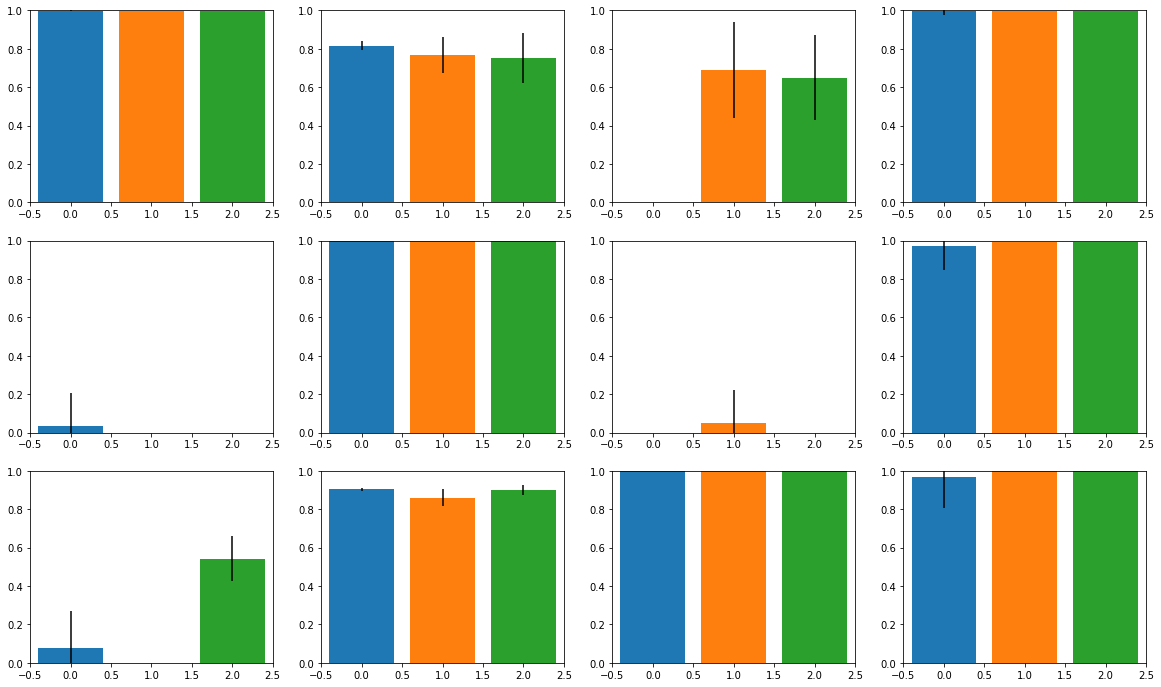

In [33]:
fig, axes = plt.subplots(3,4, figsize=(20,12))

r2_means = [CANN_r2_mean, ICNN_r2_mean, NODE_r2_mean]
r2_stdvs = [CANN_r2_stdv, ICNN_r2_stdv, NODE_r2_stdv]
for x, model_r2_mean, model_r2_stdv in zip(xs, r2_means, r2_stdvs):
    for ax, row_r2_mean, row_r2_stdv in zip(axes, model_r2_mean, model_r2_stdv):
        for axi, r2_mean, r2_stdv in zip(ax, row_r2_mean, row_r2_stdv):
            axi.bar(x, r2_mean)
            axi.errorbar(x, r2_mean, r2_stdv, color='black')
            axi.set(xlim=[-0.5,2.5], ylim=[0,1])
fig.savefig('Figures/fig_rubber_R2.jpeg')